In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
print("Tensorflow version:", tf.__version__)

## Prepare Dataset

In [ ]:
train_df_path ='../07. Pemodelan Data (Data Mining)/dataset/Dataset_clean(penelitian).csv'


In [ ]:
train_df = pd.read_csv(train_df_path, sep=',', header=None, usecols=[1,2], skiprows=1)

train_df.columns = ['full_text', 'emotion']

In [ ]:
train_df.head(10)

In [ ]:
train_df.head(10)

In [ ]:
def get_label_idx(label):
    if label == 'Fear':
        return 5
    if label == 'Sad':
        return 4
    if label == 'Love':
        return 3
    if label == 'Joy':
        return 2
    if label == 'Anger':
        return 1
    if label == 'Neutral':
        return 0
train_df['emotion'] = train_df['emotion'].apply(get_label_idx)

In [ ]:
train_df

In [ ]:
# Define the function to join the list of tokens as a single document string
def join_text_list(texts):
    try:
        texts = ast.literal_eval(texts)
        return ' '.join([text for text in texts])
    except (ValueError, SyntaxError):
        return None  # or return an empty string if you prefer

# Apply the function to the 'full_text' column
train_df["full_text"] = train_df["full_text"].apply(join_text_list)

# Display the first few rows of the preprocessed column
train_df

In [ ]:
jumlah_netral = len(train_df[train_df['emotion'] == 0])
jumlah_marah = len(train_df[train_df['emotion'] == 1])
jumlah_senang = len(train_df[train_df['emotion'] == 2])
jumlah_cinta = len(train_df[train_df['emotion'] == 3])
jumlah_sedih = len(train_df[train_df['emotion'] == 4])
jumlah_takut = len(train_df[train_df['emotion'] == 5])

print("Jumlah Netral: ", jumlah_netral)
print("Jumlah Marah: ", jumlah_marah)
print("Jumlah Senang: ", jumlah_senang)
print("Jumlah Cinta: ", jumlah_cinta)
print("Jumlah Sedih: ", jumlah_sedih)
print("Jumlah Takut: ", jumlah_takut)

In [ ]:
# Split dataset menjadi fitur (X) dan label (y)
X_train = train_df['full_text']
y_train = train_df['emotion']


In [ ]:
##split dataset
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

## Generate Padded Sequence

In [ ]:
# Parameters

vocab_size = 60000 #ukuran kosakata yang akan digunakan
max_length = 50 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import re

# Define the "all_texts" variable
X_train = [str(text) for text in X_train]
X_valid = [str(text) for text in X_valid]

# Tokenisasi
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Gabungkan semua teks untuk membuat kamus indeks kata
all_texts = list(X_train) + list(X_valid)

# Membuat kamus indeks kata
tokenizer.fit_on_texts(all_texts)
word_index = tokenizer.word_index
word_index


# Konversi kalimat menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type, padding="post")

valid_sequences = tokenizer.texts_to_sequences(X_valid)
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type, padding="post")




### kamus data untuk api Training

In [ ]:
# import pickle

# Simpan tokenizer ke dalam file
# with open('tokenizer-2classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
print(train_padded[0])

## Word Embedding

In [ ]:
from gensim.models import Word2Vec

# Gabungkan data pelatihan dan validasi
sentences = [sentence.split() for sentence in X_train] + [sentence.split() for sentence in X_valid]

# Latih model Word2Vec
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=1, workers=4)

In [ ]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
        

In [ ]:
embedding_matrix

In [ ]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[345])
print(word)

## Build and Compile Model

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


In [ ]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


## Train Model

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

num_epochs = 200

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

# Train the model
history = model.fit(
    train_padded, 
    y_train, 
    batch_size=128, 
    epochs=num_epochs, 
    validation_data=(valid_padded, y_valid), 
    callbacks=[early_stopping, reduce_lr]
)


202/202 ━━━━━━━━━━━━━━━━━━━━ 69s 342ms/step - accuracy: 0.4109 - loss: 1.4807 - val_accuracy: 0.4735 - val_loss: 1.3802 - learning_rate: 0.0010
Epoch 5/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 65s 315ms/step - accuracy: 0.4304 - loss: 1.4448 - val_accuracy: 0.4794 - val_loss: 1.3444 - learning_rate: 0.0010
Epoch 6/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 56s 279ms/step - accuracy: 0.4548 - loss: 1.4118 - val_accuracy: 0.5084 - val_loss: 1.3139 - learning_rate: 0.0010
Epoch 7/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 35s 172ms/step - accuracy: 0.4632 - loss: 1.3831 - val_accuracy: 0.5105 - val_loss: 1.2956 - learning_rate: 0.0010
Epoch 8/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.4798 - loss: 1.3468 - val_accuracy: 0.5272 - val_loss: 1.2627 - learning_rate: 0.0010
Epoch 9/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.4862 - loss: 1.3288 - val_accuracy: 0.5247 - val_loss: 1.2536 - learning_rate: 0.0010
Epoch 10/200
202/202 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.5031 

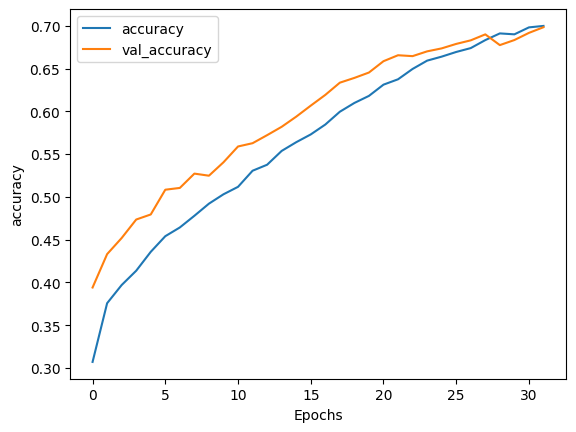

In [25]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

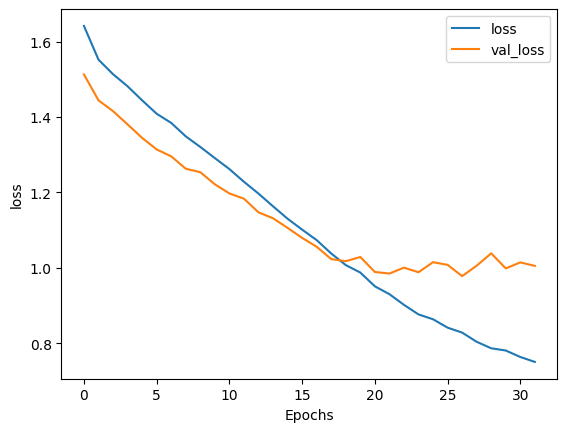

In [26]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [27]:
#sklearn report
from sklearn.metrics import classification_report

loss, accuracy = model.evaluate(valid_padded, y_valid)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

y_pred = model.predict(valid_padded)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_valid, y_pred))

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6913 - loss: 0.9673
Loss:  0.9779702425003052
Accuracy:  0.6829268336296082
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
              precision    recall  f1-score   support

           0       0.38      0.26      0.31       306
           1       0.61      0.81      0.70       577
           2       0.68      0.78      0.73       647
           3       0.72      0.63      0.68       466
           4       0.83      0.73      0.78       492
           5       0.79      0.67      0.73       382

    accuracy                           0.68      2870
   macro avg       0.67      0.65      0.65      2870
weighted avg       0.68      0.68      0.68      2870



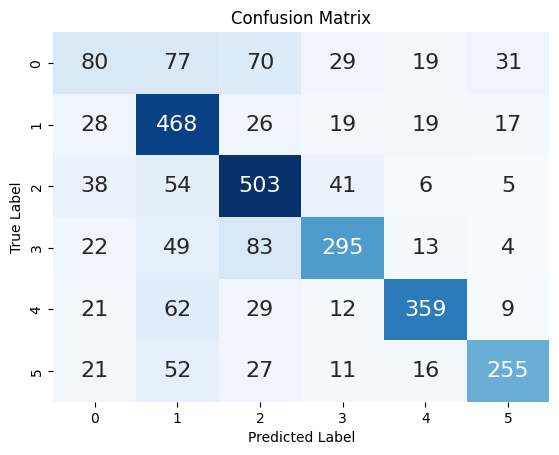

In [28]:
# create a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Membuat confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Membuat heatmap dari confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [29]:
print(cm)

[[ 80  77  70  29  19  31]
 [ 28 468  26  19  19  17]
 [ 38  54 503  41   6   5]
 [ 22  49  83 295  13   4]
 [ 21  62  29  12 359   9]
 [ 21  52  27  11  16 255]]


In [30]:
#predict another data input from the model
def predict_emotion(text):
    # Tokenisasi
    text = [text]
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type, padding="post")
    
    # Prediksi
    pred = model.predict(padded)

    print("Prediksi:", pred)
    pred = np.argmax(pred, axis=1)
    

    # Mengembalikan label emosi
    if pred == 0:
        return "Neutral"
    elif pred == 1:
        return "Anger"
    elif pred == 2:
        return "Joy"
    elif pred == 3:
        return "Love"
    elif pred == 4:
        return "Sad"
    elif pred == 5:
        return "Fear"

#make 10 senteces twitter in predict emotion
predict_emotion("saya sangat senang hari ini")
predict_emotion("saya sangat marah hari ini")
predict_emotion("saya sangat cinta hari ini")
predict_emotion("saya sangat sedih hari ini")
predict_emotion("saya sangat takut hari ini")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediksi: [[0.2816551  0.08687936 0.09754374 0.01884701 0.31518713 0.19988759]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Prediksi: [[0.1438005  0.6432886  0.01327431 0.01763984 0.05489031 0.12710638]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi: [[0.09173086 0.00202303 0.29459378 0.58798206 0.02232044 0.00134985]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Prediksi: [[4.5076068e-02 7.2244489e-05 8.4076572e-04 4.6349292e-06 9.4791502e-01
  6.0913404e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediksi: [[1.4120658e-01 8.9477353e-02 7.7525862e-03 3.8192747e-04 1.2128837e-01
  6.3989317e-01]]


'Fear'

In [31]:
#save model
model.save('./model/model-bilstmcnn.h5')